<a href="https://colab.research.google.com/github/gloria256/ANALITICA-CLASIFICAR-IMAGENES/blob/master/REDES_NEURONALES_HOUSING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# APLICACION DE REDES NEURONALES A HOUSING

#1. importacionn de librerias, base de datos y funciones desde drive

In [1]:
# IMPORTACION DE LIBRERIAS BASICAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ACCESO A GOOGLE DRIVE
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# ACCESO DE BASE DE DATOS
Bd_housing = '1nq_ms3a1XAeIw811BAKupTDEznKD-ijh' 
downloaded = drive.CreateFile({'id': Bd_housing})
downloaded.GetContentFile('housing.csv') 

# ACCESO ARCHIVO DE FUNCIONES
Funciones = '1RK1rfMWxgoaF1LLm0yp8vD5JSSbk6xCs' 
downloaded = drive.CreateFile({'id': Funciones})
downloaded.GetContentFile('Funciones.py') 

# LECTURA DE BASE DE DATOS CON PANDAS
from Funciones import pre_exploratorio_housing
Bd=pd.read_csv('housing.csv')
Bd.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#2. Análisis exploratorio Inicial: Particionar los datos, quitar la salida de los datos de entrenamiento y completar datos NUM y CAT.

In [0]:
# IMPORTACIÓN DE LIBRERIAS NECESARIAS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

# PARTCIÓN: 70% xtrain, 30% test
Xtrain, Xtest = train_test_split(Bd,test_size=0.3,random_state=42)
Xtrain, Xvalid = train_test_split(Xtrain,test_size=0.3,random_state=42)


# COLUMNA DE SALIDA, COLUMNAS NUMÉRICAS Y COLUMNAS CATEGÓRICAS
col_sal='median_house_value'
col_num=['longitude','latitude','housing_median_age','total_rooms','total_bedrooms',
        'population','households','median_income']
col_cat=['ocean_proximity']

# FUNCIÓN PARA COMPLETAR FALTANTES XTRAIN Y XTEST
Xtrain, Ytrain= pre_exploratorio_housing(Xtrain,col_sal,col_num,col_cat,estra_num='median',estra_cat='most_frequent')
Xtest, Ytest= pre_exploratorio_housing(Xtest,col_sal,col_num,col_cat,estra_num='median',estra_cat='most_frequent')
Xvalid, Yvalid= pre_exploratorio_housing(Xvalid,col_sal,col_num,col_cat,estra_num='median',estra_cat='most_frequent')


# CODIFICACIÓN DE COLUMNAS CATEGÓRICAS
codificador = OrdinalEncoder()
Xtrain['ocean_proximity'].value_counts()
Xtrain['ocean_proximity'] = codificador.fit_transform(Xtrain[['ocean_proximity']])
Xvalid['ocean_proximity'].value_counts()
Xvalid['ocean_proximity'] = codificador.fit_transform(Xvalid[['ocean_proximity']])
Xtest['ocean_proximity'].value_counts()
Xtest['ocean_proximity'] = codificador.fit_transform(Xtest[['ocean_proximity']])

In [3]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10113 entries, 6157 to 1101
Data columns (total 9 columns):
longitude             10113 non-null float64
latitude              10113 non-null float64
housing_median_age    10113 non-null float64
total_rooms           10113 non-null float64
total_bedrooms        10113 non-null float64
population            10113 non-null float64
households            10113 non-null float64
median_income         10113 non-null float64
ocean_proximity       10113 non-null float64
dtypes: float64(9)
memory usage: 790.1 KB


In [4]:
Xtrain.shape

(10113, 9)

#3. Instalar TensorFlow

In [5]:
!pip install tensorflow==2.0.0-alpha0
!pip install keras

#4. Pasar Xtrain,Xtest y Xvalid a numpy array, ya que las entradas a la red neuronal deben ser numpy arrays.

In [6]:
Xtrain=np.array(Xtrain)
Xvalid=np.array(Xvalid)
Xtest=np.array(Xtest)
#Xtrain=Xtrain.reshape(14448,1,9)  #.astype('float32') / 255
#Ytrain=Ytrain                     #.astype('float32')
#A=np.zeros((3,14448,3))          # matriz con 3 capas, 1 fila, 3 columnas

Xtrain.shape

(10113, 9)

#5. Defimicion del modelo de la red neuronal con Keras.

In [0]:
import tensorflow as tf
from tensorflow import keras
#print(tf.__version__)

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
#model.add(keras.layers.Flatten(input_shape=[1, 9]))# se comenta porque ya estan las entradas
model.add(keras.layers.Dense(30, input_shape=(9,), activation="relu"))     #input_shape=(9,) 9 son las entradas a una neurona de la capa densa
model.add(keras.layers.Dense(10, activation="sigmoid"))
model.add(keras.layers.Dense(1))                                           #no tiene activacion porque los valores de la salida estan por fuera del rango 0,1

In [8]:
model.layers

In [9]:
#VISUALIZACION DE LAS CAPAS Y LAS NEURONAS DE LA RED NEURONAL
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                300       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________


#6. Comilacion del modelo creado de la red neuronal, entrenamiento y gráfica de errores.

In [0]:
#COMPILACIÓN DEL MODELO
model.compile(loss=keras.losses.mse,        # sea una funcion derivable y continuo
              optimizer="sgd",              
              metrics=[keras.losses.mae])   # loss como metrics, miren para el mismo sentido o lado, error absoluto y accuarcy acierto

In [11]:
#ENTRENAMIENTO DE LA RED NEURONAL CON XTRAIN
history = model.fit(Xtrain, Ytrain, epochs=30, batch_size=30,validation_data=(Xvalid,Yvalid))

Train on 10113 samples, validate on 4335 samples
Epoch 1/30
10113/10113 [==============================] - 1s 77us/sample - loss: 18638377198.3055 - mean_absolute_error: 101678.1562 - val_loss: 13694249154.8789 - val_mean_absolute_error: 91201.2500
Epoch 2/30
10113/10113 [==============================] - 1s 58us/sample - loss: 13283797749.4061 - mean_absolute_error: 90771.7344 - val_loss: 13655270498.3253 - val_mean_absolute_error: 92096.5781
Epoch 3/30
10113/10113 [==============================] - 1s 56us/sample - loss: 13281382487.1813 - mean_absolute_error: 91020.0469 - val_loss: 13662132011.4048 - val_mean_absolute_error: 91792.6797
Epoch 4/30
10113/10113 [==============================] - 1s 58us/sample - loss: 13279921442.4017 - mean_absolute_error: 90965.8906 - val_loss: 13666840040.9689 - val_mean_absolute_error: 91665.9922
Epoch 5/30
10113/10113 [==============================] - 1s 57us/sample - loss: 13281994947.0187 - mean_absolute_error: 90907.9297 - val_loss: 1365665428

In [12]:
#IMPRESION DE LAS ÉPOCAS
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [13]:
#IMPRESION DE LAS ETIQUETAS DE LOS ERRORES
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

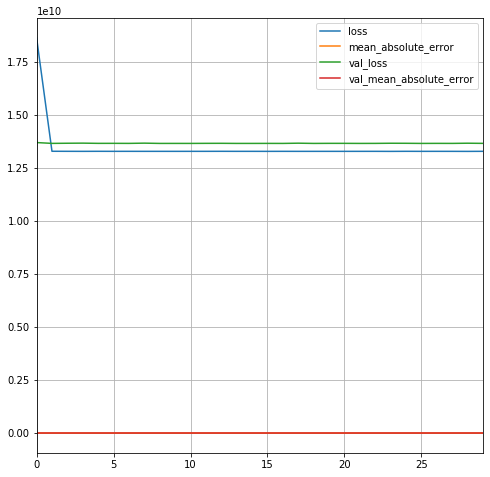

In [14]:
#GRAFICA DE LOS ERROES DE ACUERDO AL CONJUNTO DE VALIDACIÓN
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 8))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
#save_fig("keras_learning_curves_plot")
plt.show()

#7. EVALUACIÓN DEL MODELO  DE LA RED NEURONAL CON EL CONJUNTO DE TEST (Xtest,Ytes).

In [15]:
#EVALUACION DEL MODELO CON EL CONJUNTO DE TEST
model.evaluate(Xtest, Ytest)

6192/6192 [==============================] - 0s 29us/sample - loss: 13122340287.1731 - mean_absolute_error: 90515.5234


[13122340287.173126, 90515.52]

In [16]:
#model.preict, xtest
Ypred = model.predict(Xtest, batch_size=30)
Ypred

array([[206606.64],
       [206606.64],
       [206606.64],
       ...,
       [206606.64],
       [206606.64],
       [206606.64]], dtype=float32)

#8. Grafica de los valores reales de la salida(median_house_value) y los valores estimados()ypred.

<function matplotlib.pyplot.show>

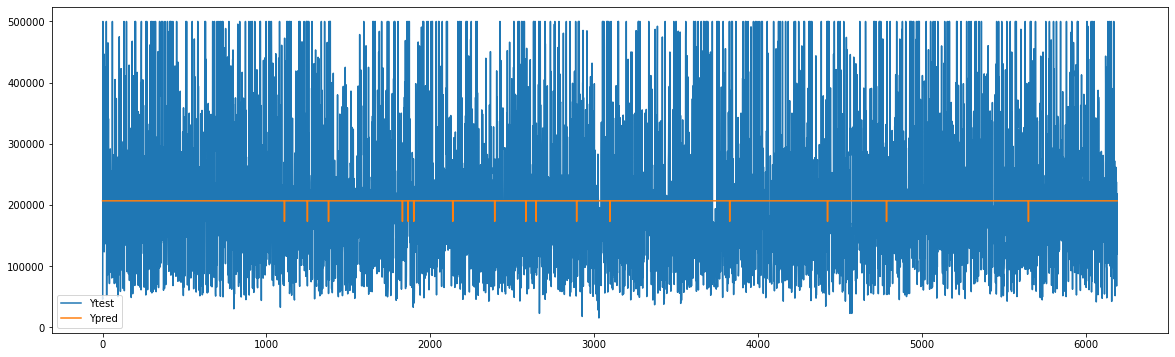

In [17]:
plt.figure(figsize=(20, 6))
plt.plot(np.array(Ytest),label='Ytest')
plt.plot(np.array(Ypred),label='Ypred')
plt.legend()
plt.show